In [1]:
# Parameters
# working_dir = "/nfs/team205/heart/Vitro/TF_selection/foetal_vCM_left_compact-vs-trabeculated_downstream/CO_in-silico-perturbation_papermill"
path_to_oracle_object = "/nfs/team205/heart/anndata_objects/Foetal/celloracle/foetal_AtrialCM.celloracle.oracle"
path_to_oracle_links = "/nfs/team205/heart/anndata_objects/Foetal/celloracle/foetal_AtrialCM_links.celloracle.links"

# path_to_TFs = 

clusters = ['AtrialCardiomyocytesLeft_t1',
 'AtrialCardiomyocytesLeft_t2',
 'AtrialCardiomyocytesLeft_t3']
cell_group_name = "AtrialCM-Left"

path_to_res_dict = f"/nfs/team205/heart/anndata_objects/Foetal/celloracle/{cell_group_name}_in-silico_perturbation_May2025_2.pkl"
path_to_plots = f"/nfs/team205/heart/anndata_objects/Foetal/celloracle/figures_pm/{cell_group_name}_May2025_2"

ref: https://morris-lab.github.io/CellOracle.documentation/notebooks/04_Network_analysis/Network_analysis_with_Paul_etal_2015_data.html

# Import libraries

In [2]:
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [3]:
import celloracle as co
co.__version__

'0.20.0'

In [4]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [5]:
sc.settings.set_figure_params(dpi=120)

# Make out directory

In [6]:
if not os.path.exists(path_to_plots):
    # Create the directory
    os.makedirs(path_to_plots)
    print("Directory created successfully")
else:
    print("Directory already exists")

Directory already exists


# Load oracle object

In [7]:
# Load
oracle = co.load_hdf5(path_to_oracle_object)

In [8]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :5664
Auto-selected k is :141


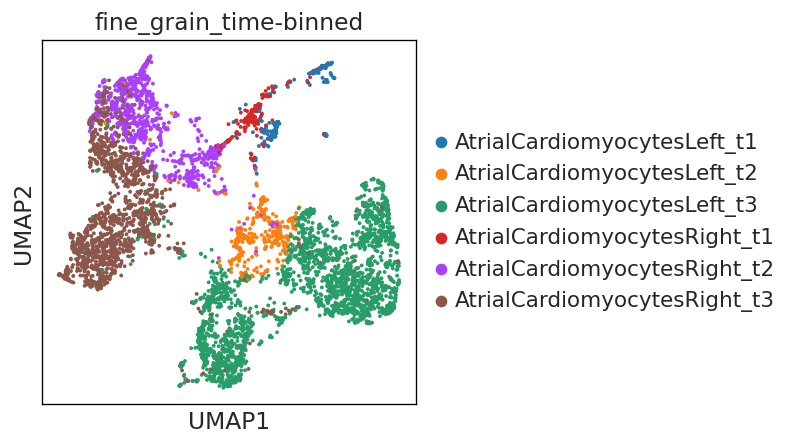

In [9]:
%matplotlib inline
# Check clustering data
sc.pl.umap(oracle.adata, color='fine_grain_time-binned')

# In silico TF perturbation analysis

In [10]:
# Read in 
regulons = utils.read_pkl('/nfs/team205/heart/pyscenic/plus/baseGRN_forCO/AtrialCM_baseGRN_act.pkl')
list_of_TFs = list(regulons.keys())

# select TFs which are in the oracle object
list_of_TFs = [x for x in list_of_TFs if x in oracle.adata.var_names]

print(len(list_of_TFs))
list_of_TFs[:5]

263


['ZNF730', 'PHF21A', 'CREB1', 'CREB3L4', 'MXD1']

In [11]:
'''
# Check gene expressions
# will be saved to a separated file
sc.settings.set_figure_params(dpi=80)
sc.pl.draw_graph(oracle.adata, color=list_of_TFs, ncols=6,
                 layer="imputed_count", use_raw=False, cmap="RdPu",
                 show=False, save='_TF_expression.png'
                )
'''

'\n# Check gene expressions\n#\xa0will be saved to a separated file\nsc.settings.set_figure_params(dpi=80)\nsc.pl.draw_graph(oracle.adata, color=list_of_TFs, ncols=6,\n                 layer="imputed_count", use_raw=False, cmap="RdPu",\n                 show=False, save=\'_TF_expression.png\'\n                )\n'

# Search for best min_mass.

In [ ]:
n_grid = 40
n_neighbors = 100

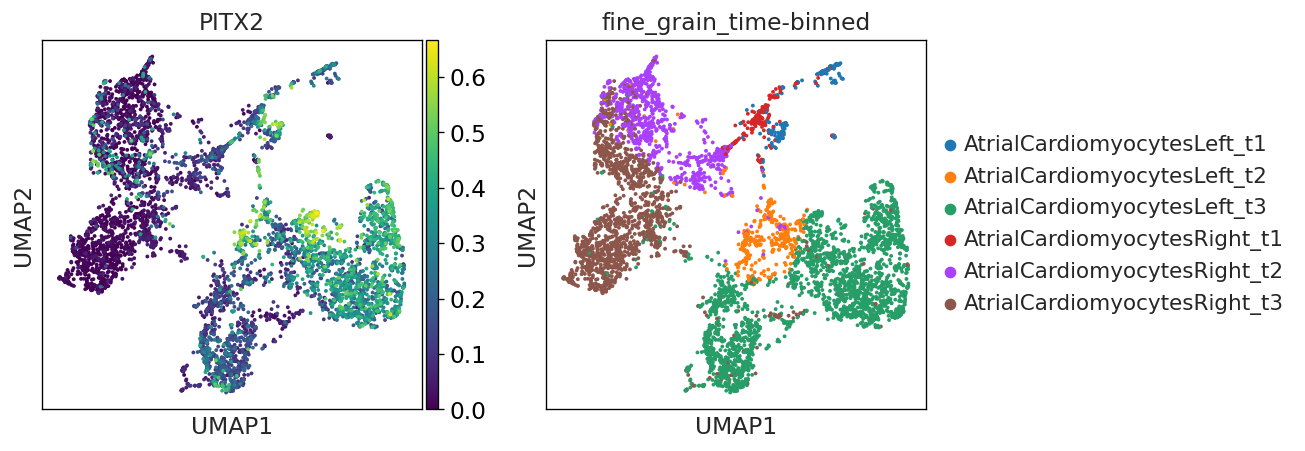

In [20]:
# Check gene expression
goi = "PITX2"
sc.pl.umap(oracle.adata, color=[goi, oracle.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

In [21]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

In [22]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=n_neighbors,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

In [24]:
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=n_neighbors)

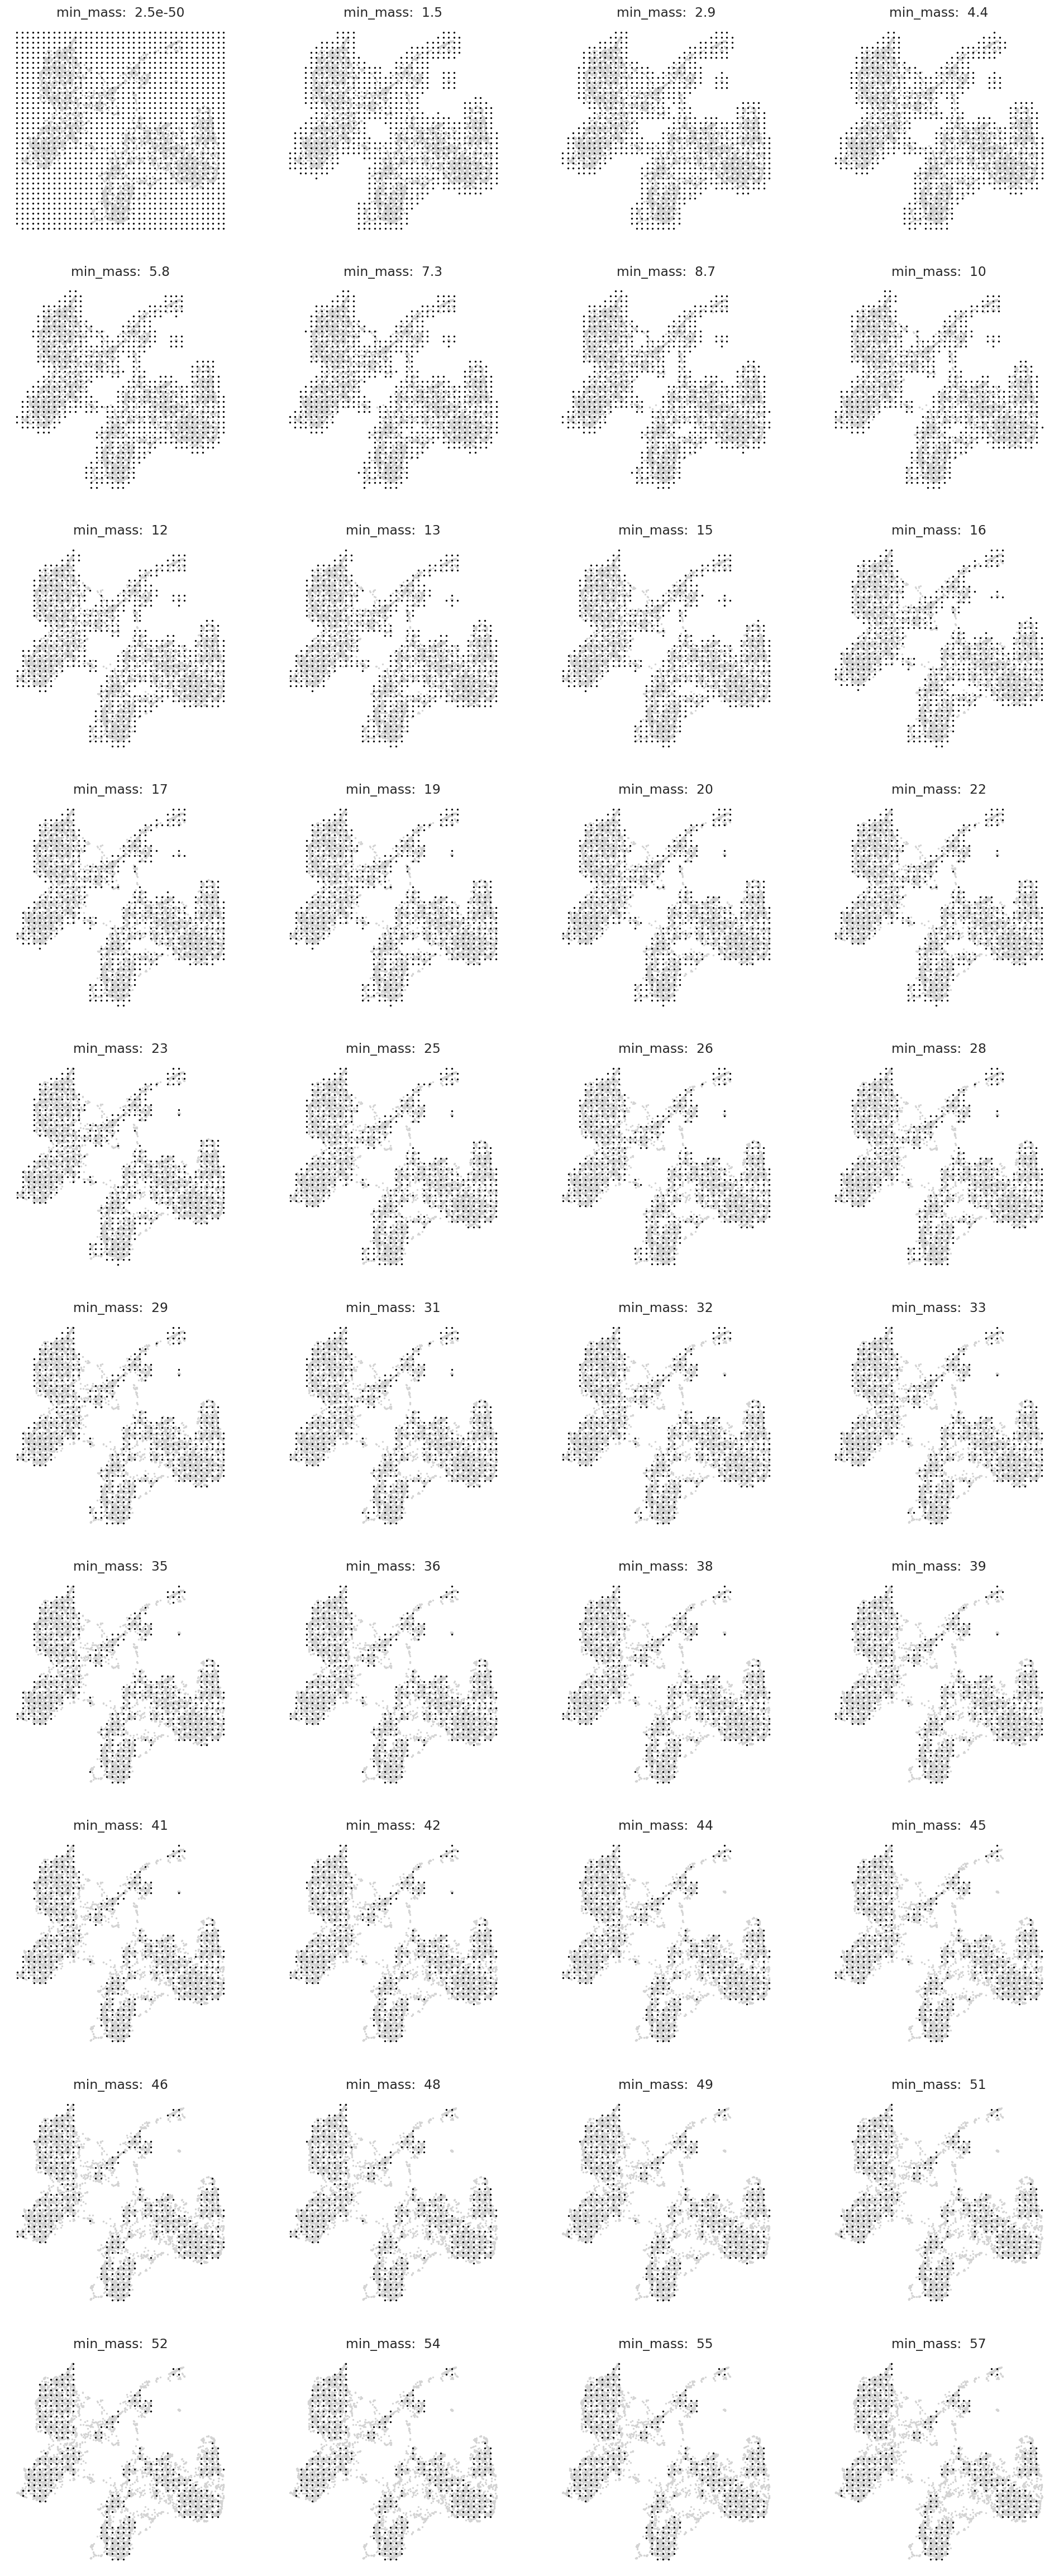

In [25]:
oracle.suggest_mass_thresholds(n_suggestion=40)

In [28]:
min_mass = 31
scale_simulation = 5

In [29]:
%matplotlib inline

# Calculating pseudotime gradient vectors

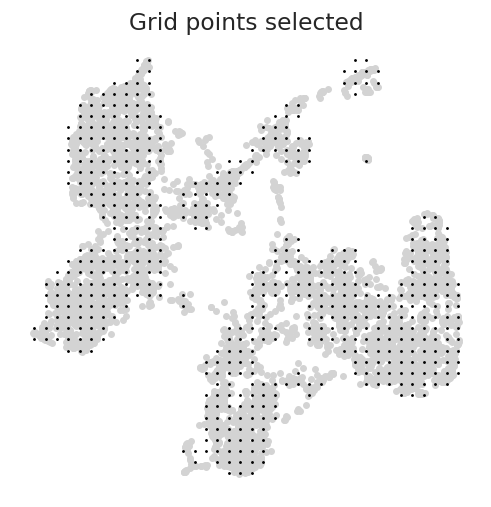

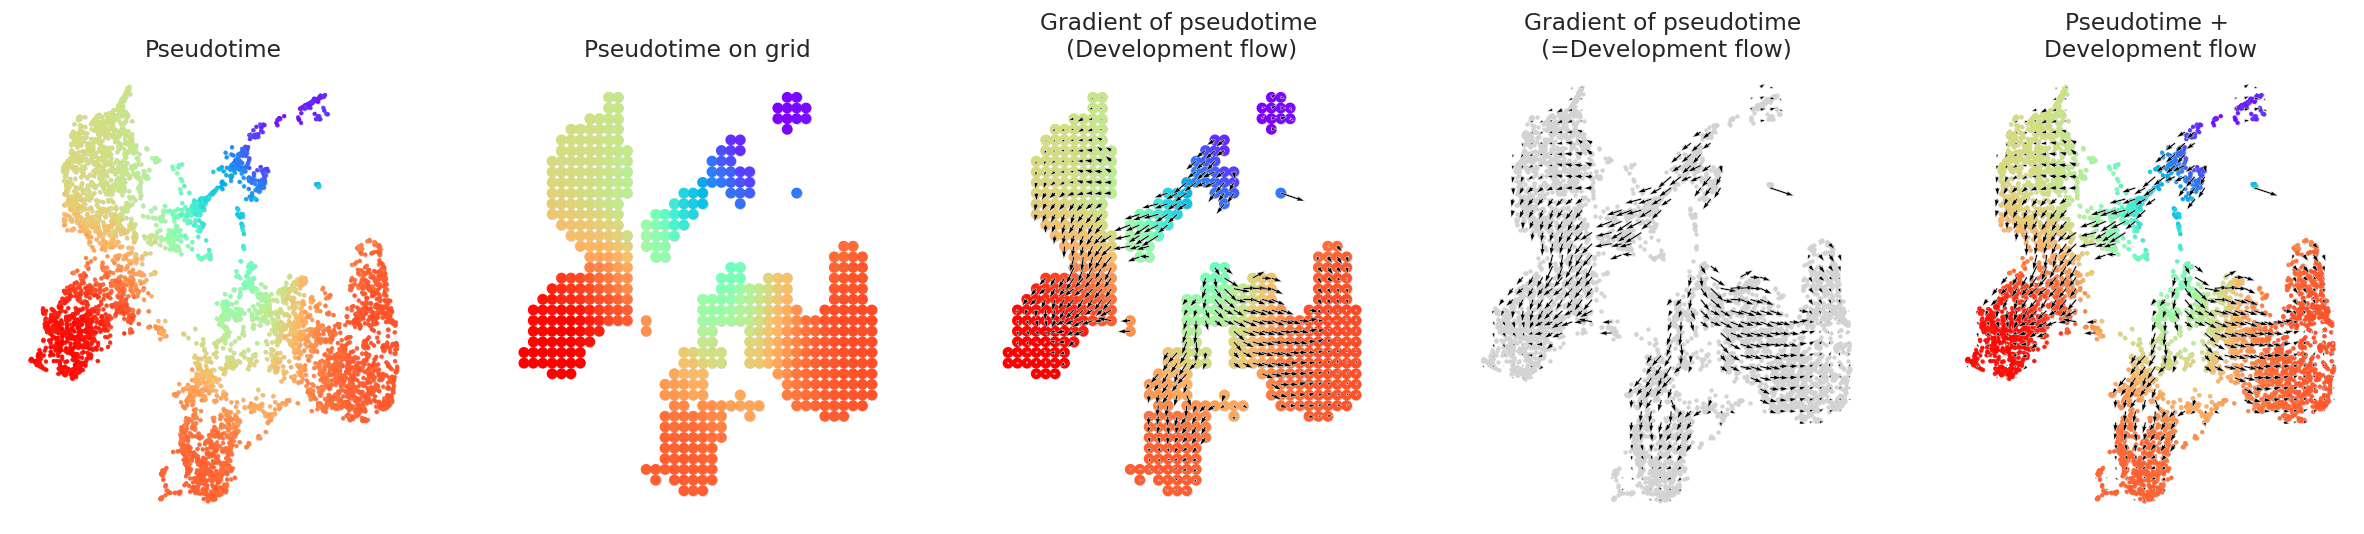

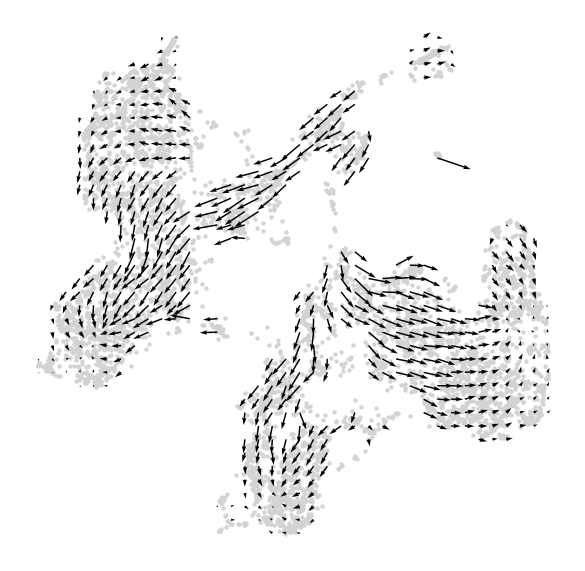

In [30]:
from celloracle.applications import Gradient_calculator
# Instantiate Gradient calculator object
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="t")
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=n_neighbors)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)

# convert the pseudotime data into grid points.
# For this calculation we can chose one of two methods.
gradient.transfer_data_into_grid(args={"method": "knn", "n_knn":50})

# Calculate graddient
gradient.calculate_gradient()
# Show results
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)
# Visualize results
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)

# Perturbation

In [31]:
from tqdm import tqdm

In [32]:
list_of_TFs = ['PITX2']

In [33]:
from celloracle.applications import Oracle_development_module

# not showing plots
matplotlib.use('Agg')

# Get cell index list for the cells of interest
cell_idx = np.where(oracle.adata.obs["fine_grain_time-binned"].isin(clusters))[0]
# Check index
print(cell_idx)

dev_dict = {}
for goi in tqdm(list_of_TFs):
    # Enter perturbation conditions to simulate signal propagation after the perturbation.
    try:
        oracle.simulate_shift(perturb_condition={goi: 0.0}, # this is KO simulation so expression=0
                          n_propagation=3)
    except:
        print(f'skippint {goi} due to an error')
        continue
    
    # Get transition probability
    oracle.estimate_transition_prob(n_neighbors=n_neighbors,
                                    knn_random=True,
                                    sampled_fraction=1)

    # Calculate embedding
    oracle.calculate_embedding_shift(sigma_corr=0.05)
    
    # prepare grid
    oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=n_neighbors)
    oracle.calculate_mass_filter(min_mass=min_mass, plot=False)
    
    # plot vector field
    fig, ax = plt.subplots(1, 2,  figsize=[13, 6])
    # Show quiver plot
    oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
    ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")
    # Show quiver plot that was calculated with randomized graph.
    oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
    ax[1].set_title(f"Randomized simulation vector")
    plt.savefig(f'{path_to_plots}/{goi}_simulation_vector.pdf')
    
    # Plot vector field with cell cluster
    fig, ax = plt.subplots(figsize=[8, 8])
    oracle.plot_cluster_whole(ax=ax, s=10)
    oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)
    plt.savefig(f'{path_to_plots}/{goi}_simulation_vector_with-clusters.pdf')
    
    
    dev = Oracle_development_module()
    # Load development flow
    dev.load_differentiation_reference_data(gradient_object=gradient)

    # Load simulation result
    dev.load_perturb_simulation_data(oracle_object=oracle,
                                     cell_idx_use=cell_idx, # Enter cell id list
                                     name=cell_group_name # Name of this cell group. You can enter any name.
                                     )

    # Calculation
    dev.calculate_inner_product()
    dev.calculate_digitized_ip(n_bins=10)
    
    # save to the dictionary
    dev_dict[goi] = dev.copy()
    
    # Let's visualize the results
    vm = 0.01
    dev.visualize_development_module_layout_0(s=5,
                                              scale_for_simulation=scale_simulation,
                                              s_grid=50,
                                              scale_for_pseudotime=scale_dev,
                                              vm=vm)
    plt.savefig(f'{path_to_plots}/{goi}_results.pdf')

[   1    2    4 ... 5659 5662 5663]


  0%|          | 0/1 [00:00<?, ?it/s]2025-05-08 22:24:04,677 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-08 22:24:04,686 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
100%|██████████| 1/1 [05:59<00:00, 359.94s/it]


In [115]:
%matplotlib inline

2025-05-08 21:38:15,504 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-08 21:38:15,513 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


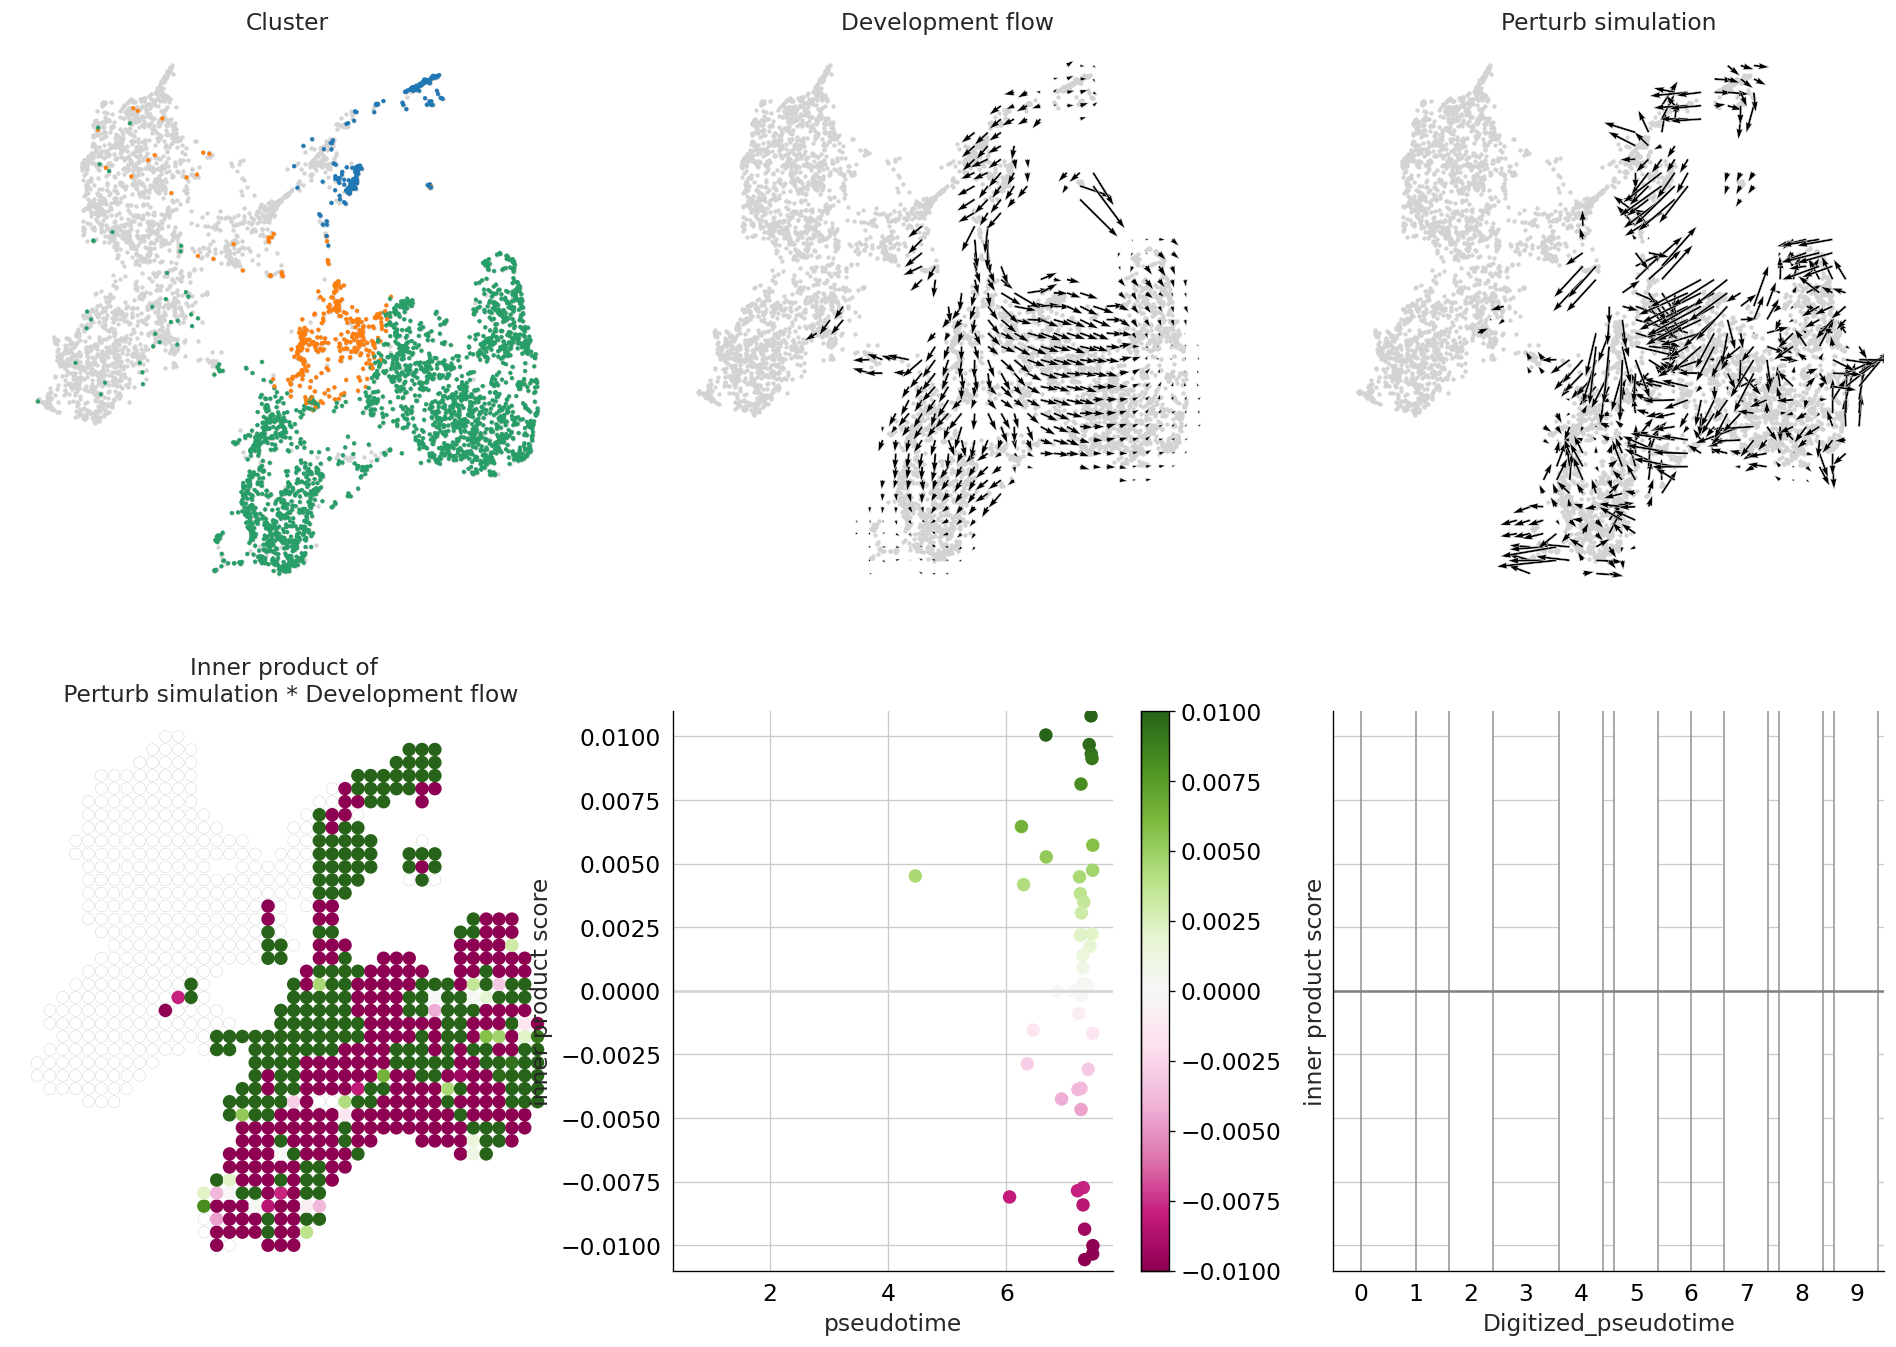

In [123]:
dev.visualize_development_module_layout_0(s=5,
                                          scale_for_simulation=scale_simulation,
                                          s_grid=50,
                                          scale_for_pseudotime=40,
                                          vm=vm)

In [124]:
?dev.visualize_development_module_layout_0

Signature:
dev.visualize_development_module_layout_0(
    scale_for_pseudotime=30,
    scale_for_simulation=30,
    s=5,
    s_grid=20,
    vm=1,
    show_background=True,
    return_fig=False,
)
Docstring: <no docstring>
File:      /software/cellgen/team205/kk18/envs/celloracle_env/lib/python3.10/site-packages/celloracle/applications/development_module.py
Type:      method

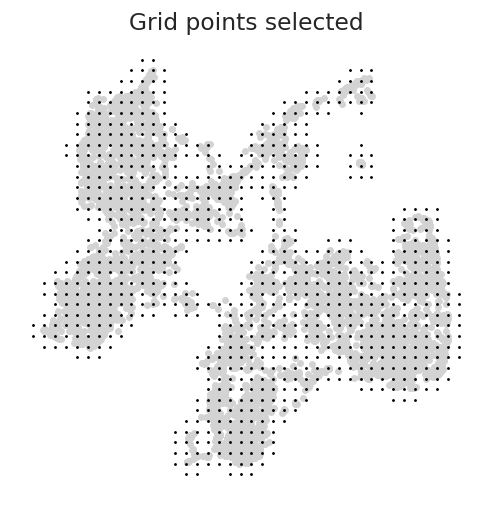

In [125]:
oracle.calculate_p_mass(smooth=0.8, n_grid=40, n_neighbors=n_neighbors)
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

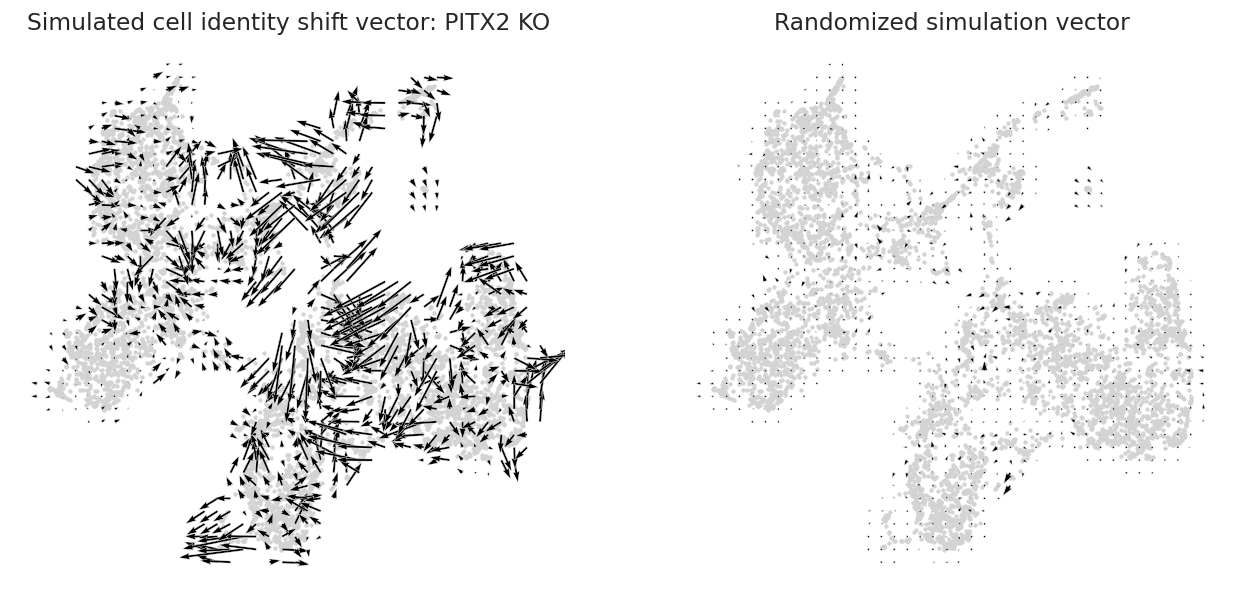

In [126]:
# plot vector field
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])
scale_simulation = 5
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")
# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")
plt.show()

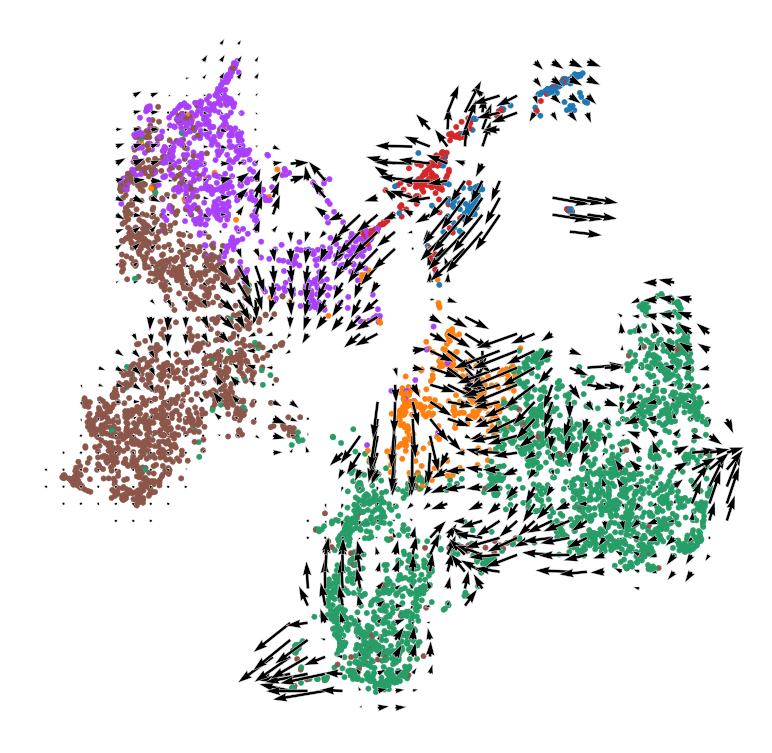

In [53]:
# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

In [55]:
oracle.adata

AnnData object with n_obs × n_vars = 5664 × 10870
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', 'age_days', 'age_days_smoothed_once', 'age_days_normalized', 'age_days_normalized_smoothed_once', 'age_days_smoothed_iteratively', 'age_days_normalized_smoothed_iteratively', 't', 'seg', 'edge', 't_sd', 'milestones', 't_binned', 'fine_grain_time-binned'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id', 'n_cells', 'symbol', 'isi

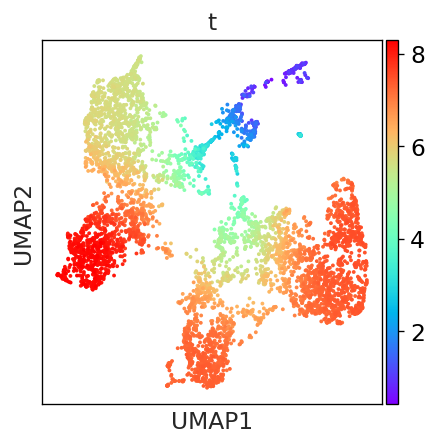

In [57]:
sc.pl.umap(adata=oracle.adata, cmap="rainbow",
                color=["t"])

In [ ]:
# save
utils.save_pkl(dev_dict, path_to_res_dict)